In [49]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType
import sys
import pandas as pd


spark = SparkSession.builder.appName("AnalyzingNetflix").master("local[*]").getOrCreate()

## 1. Loading your friend's data into a dictionary
<p><img src="https://assets.datacamp.com/production/project_1237/img/netflix.jpg" alt="Someone's feet on table facing a television"></p>
<p>Netflix! What started in 1997 as a DVD rental service has since exploded into the largest entertainment/media company by <a href="https://www.marketwatch.com/story/netflix-shares-close-up-8-for-yet-another-record-high-2020-07-10">market capitalization</a>, boasting over 200 million subscribers as of <a href="https://www.cbsnews.com/news/netflix-tops-200-million-subscribers-but-faces-growing-challenge-from-disney-plus/">January 2021</a>.</p>
<p>Given the large number of movies and series available on the platform, it is a perfect opportunity to flex our data manipulation skills and dive into the entertainment industry. Our friend has also been brushing up on their Python skills and has taken a first crack at a CSV file containing Netflix data. For their first order of business, they have been performing some analyses, and they believe that the average duration of movies has been declining. </p>
<p>As evidence of this, they have provided us with the following information. For the years from 2011 to 2020, the average movie durations are 103, 101, 99, 100, 100, 95, 95, 96, 93, and 90, respectively.</p>
<p>If we're going to be working with this data, we know a good place to start would be to probably start working with <code>pandas</code>. But first we'll need to create a DataFrame from scratch. Let's start by creating a Python object covered in <a href="https://learn.datacamp.com/courses/intermediate-python">Intermediate Python</a>: a dictionary!</p>

In [50]:
# Create the years and durations lists
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
durations = [103, 101, 99, 100, 100, 95, 95, 96, 93, 90]

# Create a dictionary with the two lists
movie_dict = movie_dict = {'years': years, 'durations': durations}

# Print the dictionary
movie_dict

{'years': [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
 'durations': [103, 101, 99, 100, 100, 95, 95, 96, 93, 90]}

## 2. Creating a DataFrame from a dictionary
<p>Perfect! We now have our friend's data stored in a nice Python object. We can already perform several operations on a dictionary to manipulate its contents (such as updating or adding to it). But a more useful structure might be a <code>pandas</code> DataFrame, a tabular data structure containing labeled axes and rows. Luckily, DataFrames can be created very easily from the dictionary created in the previous step!</p>
<p>To convert our dictionary <code>movie_dict</code> to a <code>pandas</code> DataFrame, we will first need to import the library under its usual alias. We'll also want to inspect our DataFrame to ensure it was created correctly. Let's perform these steps now.</p>

In [51]:
#Infer schema to pratice

def movie_df(data):
    df = spark.createDataFrame([movie_dict])
    df.withColumn("durations_years", func.explode(func.arrays_zip("durations", "years")))\
        .select("durations_years.years", "durations_years.durations")\
        .show()
    return df
    
# Create a DataFrame from the dictionary
df_movie = movie_df(movie_dict)

+-----+---------+
|years|durations|
+-----+---------+
| 2011|      103|
| 2012|      101|
| 2013|       99|
| 2014|      100|
| 2015|      100|
| 2016|       95|
| 2017|       95|
| 2018|       96|
| 2019|       93|
| 2020|       90|
+-----+---------+



/usr/local/spark/python/pyspark/sql/session.py:346: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


## 3. A visual inspection of our data
<p>Alright, we now have a <code>pandas</code> DataFrame, the most common way to work with tabular data in Python. Now back to the task at hand. We want to follow up on our friend's assertion that movie lengths have been decreasing over time. A great place to start will be a visualization of the data.</p>
<p>Given that the data is continuous, a line plot would be a good choice, with the dates represented along the x-axis and the average length in minutes along the y-axis. This will allow us to easily spot any trends in movie durations. There are many ways to visualize data in Python, but <code>matploblib.pyplot</code> is one of the most common packages to do so.</p>
<p><em>Note: In order for us to correctly test your plot, you will need to initalize a <code>matplotlib.pyplot</code> Figure object, which we have already provided in the cell below. You can continue to create your plot as you have learned in Intermediate Python.</em></p>

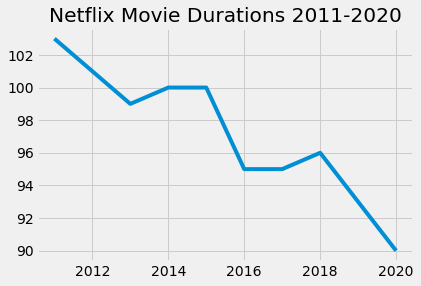

In [52]:
import matplotlib.pyplot as plt

# Converting to DataFrame to plot
durations_df = df_movie.toPandas()

#I didnt found a explicit way to do this
durations_df = pd.DataFrame({'years': durations_df['years'].explode().tolist(), 'durations': durations_df['durations'].explode()})

fig = plt.figure()

# Draw a line plot of release_years and durations
plt.plot(durations_df['years'], durations_df['durations'])

# Create a title
plt.title("Netflix Movie Durations 2011-2020")

# Show the plot
plt.show()

## 4. Loading the rest of the data from a CSV
<p>Well, it looks like there is something to the idea that movie lengths have decreased over the past ten years! But equipped only with our friend's aggregations, we're limited in the further explorations we can perform. There are a few questions about this trend that we are currently unable to answer, including:</p>
<ol>
<li>What does this trend look like over a longer period of time?</li>
<li>Is this explainable by something like the genre of entertainment?</li>
</ol>
<p>Upon asking our friend for the original CSV they used to perform their analyses, they gladly oblige and send it. We now have access to the CSV file, available at the path <code>"datasets/netflix_data.csv"</code>. Let's create another DataFrame, this time with all of the data. Given the length of our friend's data, printing the whole DataFrame is probably not a good idea, so we will inspect it by printing only the first five rows.</p>

In [53]:
# Very important, otherwise the data will not be imported correctly.
schemaStruct = StructType([ \
        StructField('show_id', StringType(), True), \
        StructField('type', StringType(), True), \
        StructField('title', StringType(), True), \
        StructField('director', StringType(), True), \
        StructField('cast', StringType(), True), \
        StructField('country', StringType(), True), \
        StructField('date_added', StringType(), True), \
        StructField('release_year', IntegerType(), True), \
        StructField('duration', IntegerType(), True), \
        StructField('description', StringType(), True), \
        StructField('genre', StringType(), True) \
        ])

In [63]:
# Read in the CSV as a DataFrame
# Some rows were malformed
# Some rows are still malformed, so I used a regex to fix this
netflix_df = spark.read.option("mode", "DROPMALFORMED").option('header', True).csv("datasets/netflix_data.csv", schema=schemaStruct)
#netflix_df = netflix_df.filter(netflix_df.release_year.rlike('^[0-9]*$'))

# Print the first five rows of the DataFrame
netflix_df.show(5)

+-------+-------+-----+-----------------+--------------------+-------------+-----------------+------------+--------+--------------------+----------------+
|show_id|   type|title|         director|                cast|      country|       date_added|release_year|duration|         description|           genre|
+-------+-------+-----+-----------------+--------------------+-------------+-----------------+------------+--------+--------------------+----------------+
|     s1|TV Show|   3%|             null|João Miguel, Bian...|       Brazil|  August 14, 2020|        2020|       4|In a future where...|International TV|
|     s2|  Movie| 7:19|Jorge Michel Grau|Demián Bichir, Hé...|       Mexico|December 23, 2016|        2016|      93|After a devastati...|          Dramas|
|     s3|  Movie|23:59|     Gilbert Chan|Tedd Chan, Stella...|    Singapore|December 20, 2018|        2011|      78|When an army recr...|   Horror Movies|
|     s4|  Movie|    9|      Shane Acker|Elijah Wood, John...|United S

## 5. Filtering for movies!
<p>Okay, we have our data! Now we can dive in and start looking at movie lengths. </p>
<p>Or can we? Looking at the first five rows of our new DataFrame, we notice a column <code>type</code>. Scanning the column, it's clear there are also TV shows in the dataset! Moreover, the <code>duration</code> column we planned to use seems to represent different values depending on whether the row is a movie or a show (perhaps the number of minutes versus the number of seasons)?</p>
<p>Fortunately, a DataFrame allows us to filter data quickly, and we can select rows where <code>type</code> is <code>Movie</code>. While we're at it, we don't need information from all of the columns, so let's create a new DataFrame <code>netflix_movies</code> containing only <code>title</code>, <code>country</code>, <code>genre</code>, <code>release_year</code>, and <code>duration</code>.</p>
<p>Let's put our data subsetting skills to work!</p>

In [55]:
# Subset the DataFrame for type "Movie"
netflix_df_movies_only = netflix_df.filter(netflix_df.type == 'Movie')

# Select only the columns of interest
netflix_movies_col_subset = netflix_df_movies_only.select(netflix_df_movies_only.title, netflix_df_movies_only.country, netflix_df_movies_only.genre, netflix_df_movies_only.release_year, netflix_df_movies_only.duration)

# Print the first five rows of the new DataFrame
netflix_movies_col_subset.show(5)

+-----+-------------+-------------+------------+--------+
|title|      country|        genre|release_year|duration|
+-----+-------------+-------------+------------+--------+
| 7:19|       Mexico|       Dramas|        2016|      93|
|23:59|    Singapore|Horror Movies|        2011|      78|
|    9|United States|       Action|        2009|      80|
|   21|United States|       Dramas|        2008|     123|
|  122|        Egypt|Horror Movies|        2019|      95|
+-----+-------------+-------------+------------+--------+
only showing top 5 rows



## 6. Creating a scatter plot
<p>Okay, now we're getting somewhere. We've read in the raw data, selected rows of movies, and have limited our DataFrame to our columns of interest. Let's try visualizing the data again to inspect the data over a longer range of time.</p>
<p>This time, we are no longer working with aggregates but instead with individual movies. A line plot is no longer a good choice for our data, so let's try a scatter plot instead. We will again plot the year of release on the x-axis and the movie duration on the y-axis.</p>
<p><em>Note: Although not taught in Intermediate Python, we have provided you the code <code>fig = plt.figure(figsize=(12,8))</code> to increase the size of the plot (to help you see the results), as well as to assist with testing. For more information on how to create or work with a <code>matplotlib</code> <code>figure</code>, refer to the <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html">documentation</a>.</em></p>

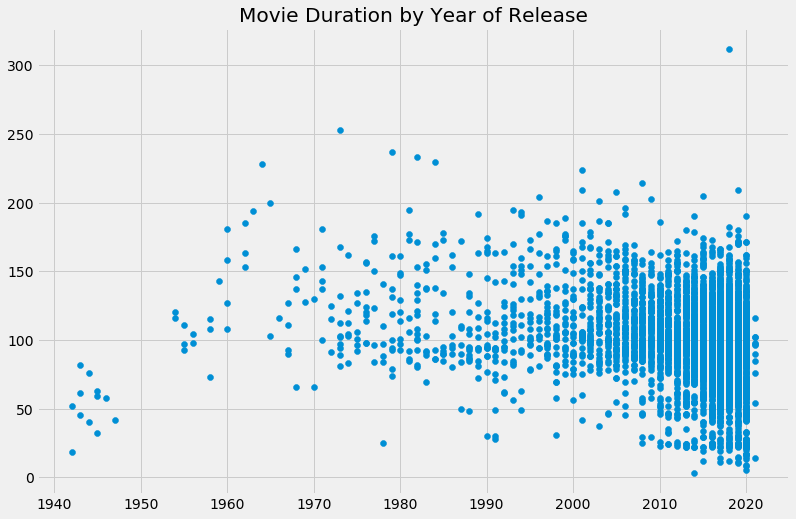

In [56]:
# Transform and converting columns
netflix_pd = netflix_movies_col_subset.toPandas()#.dropna(axis=0)

# Create a figure and increase the figure size
fig = plt.figure(figsize=(12,8))

# Create a scatter plot of duration versus year
plt.scatter(netflix_pd["release_year"], netflix_pd["duration"])

# Create a title
plt.title("Movie Duration by Year of Release")

# Show the plot
plt.show()

## 7. Digging deeper
<p>This is already much more informative than the simple plot we created when our friend first gave us some data. We can also see that, while newer movies are overrepresented on the platform, many short movies have been released in the past two decades.</p>
<p>Upon further inspection, something else is going on. Some of these films are under an hour long! Let's filter our DataFrame for movies with a <code>duration</code> under 60 minutes and look at the genres. This might give us some insight into what is dragging down the average.</p>

In [57]:
# Filter for durations shorter than 60 minutes
short_movies = netflix_movies_col_subset.filter(netflix_movies_col_subset.duration < 60)

# Print the first 20 rows of short_movies
short_movies.show(20)

+--------------------+--------------+-------------+------------+--------+
|               title|       country|        genre|release_year|duration|
+--------------------+--------------+-------------+------------+--------+
|           #Rucker50| United States|Documentaries|        2016|      56|
|100 Things to do ...| United States|Uncategorized|        2014|      44|
|13TH: A Conversat...|          null|Uncategorized|        2017|      37|
|   3 Seconds Divorce|        Canada|Documentaries|        2018|      53|
|      A 3 Minute Hug|        Mexico|Documentaries|        2019|      28|
|A Christmas Speci...|        France|Uncategorized|        2016|      22|
|A Family Reunion ...| United States|Uncategorized|        2019|      29|
|A Go! Go! Cory Ca...| United States|     Children|        2020|      22|
|A Go! Go! Cory Ca...|          null|     Children|        2020|      22|
|A Go! Go! Cory Ca...|          null|     Children|        2020|      21|
|A Grand Night In:...|United Kingdom|D

## 8. Marking non-feature films
<p>Interesting! It looks as though many of the films that are under 60 minutes fall into genres such as "Children", "Stand-Up", and "Documentaries". This is a logical result, as these types of films are probably often shorter than 90 minute Hollywood blockbuster. </p>
<p>We could eliminate these rows from our DataFrame and plot the values again. But another interesting way to explore the effect of these genres on our data would be to plot them, but mark them with a different color.</p>
<p>In Python, there are many ways to do this, but one fun way might be to use a loop to generate a list of colors based on the contents of the <code>genre</code> column. Much as we did in Intermediate Python, we can then pass this list to our plotting function in a later step to color all non-typical genres in a different color!</p>
<p><em>Note: Although we are using the basic colors of red, blue, green, and black, <code>matplotlib</code> has many named colors you can use when creating plots. For more information, you can refer to the documentation <a href="https://matplotlib.org/stable/gallery/color/named_colors.html">here</a>!</em></p>

In [58]:

### Instead of creating a function, I created a dictionary and used a udf with lambda, maybe ther is some way of just use the lambda? The questioning remains
dict_color = {'Children':'red', 'Documentaries':'blue', 'Stand-Up':'green'}


define_color_udf = func.udf(lambda x: dict_color.get(x, 'black'), StringType())

In [59]:
netflix_movies_col_subset = netflix_movies_col_subset.withColumn('color', define_color_udf(netflix_movies_col_subset.genre))

## 9. Plotting with color!
<p>Lovely looping! We now have a <code>colors</code> list that we can pass to our scatter plot, which should allow us to visually inspect whether these genres might be responsible for the decline in the average duration of movies.</p>
<p>This time, we'll also spruce up our plot with some additional axis labels and a new theme with <code>plt.style.use()</code>. The latter isn't taught in Intermediate Python, but can be a fun way to add some visual flair to a basic <code>matplotlib</code> plot. You can find more information on customizing the style of your plot <a href="https://matplotlib.org/stable/tutorials/introductory/customizing.html">here</a>!</p>

In [60]:
netflix_movies_col_subset_pd = netflix_movies_col_subset.toPandas()

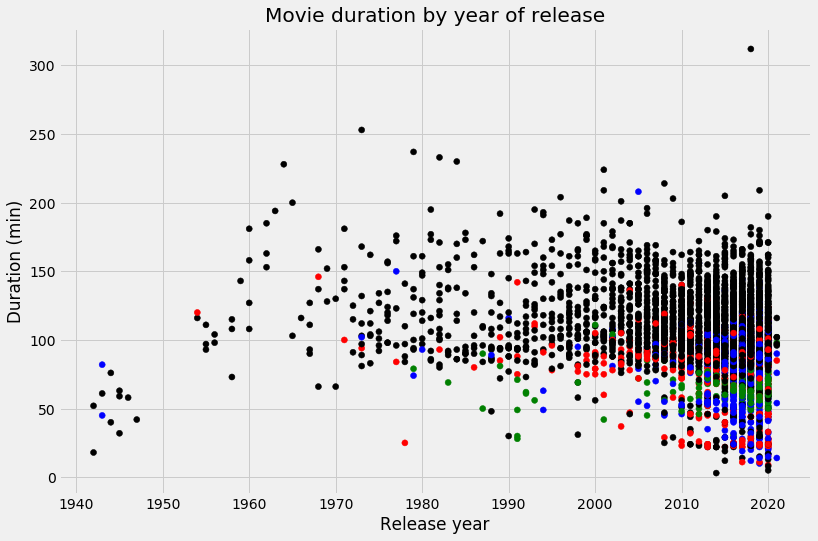

In [61]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))

# Create a scatter plot of duration versus release_year
plt.scatter(netflix_movies_col_subset_pd["release_year"], netflix_movies_col_subset_pd["duration"], c=netflix_movies_col_subset_pd['color'])

# Create a title and axis labels
plt.title("Movie duration by year of release")
plt.xlabel("Release year")
plt.ylabel("Duration (min)")

# Show the plot
plt.show()

## 10. What next?
<p>Well, as we suspected, non-typical genres such as children's movies and documentaries are all clustered around the bottom half of the plot. But we can't know for certain until we perform additional analyses. </p>
<p>Congratulations, you've performed an exploratory analysis of some entertainment data, and there are lots of fun ways to develop your skills as a Pythonic data scientist. These include learning how to analyze data further with statistics, creating more advanced visualizations, and perhaps most importantly, learning more advanced ways of working with data in <code>pandas</code>. This latter skill is covered in our fantastic course <a href="www.datacamp.com/courses/data-manipulation-with-pandas">Data Manipulation with pandas</a>.</p>
<p>We hope you enjoyed this application of the skills learned in Intermediate Python, and wish you all the best on the rest of your journey!</p>

In [48]:
# Are we certain that movies are getting shorter?
are_movies_getting_shorter = "No"